### Objective

1. Introduce the concept of SSL
2. Compare the performance on CIFAR10 dataset:
    - CNN on small labelled dataset
    - CNN on small labelled dataset + augmentation
    - CNN on small labelled dataset + SSL on large unlabelled dataset
    - CNN on small labelled dataset + SSL on large unlabelled dataset + augmentation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import torchsummary
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Download the dataset
transform = transforms.Compose(
    [transforms.ToTensor()])

data_path = os.path.expanduser('~/.cache/torch/')

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)


Files already downloaded and verified


In [4]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/nipun.batra/.cache/torch/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

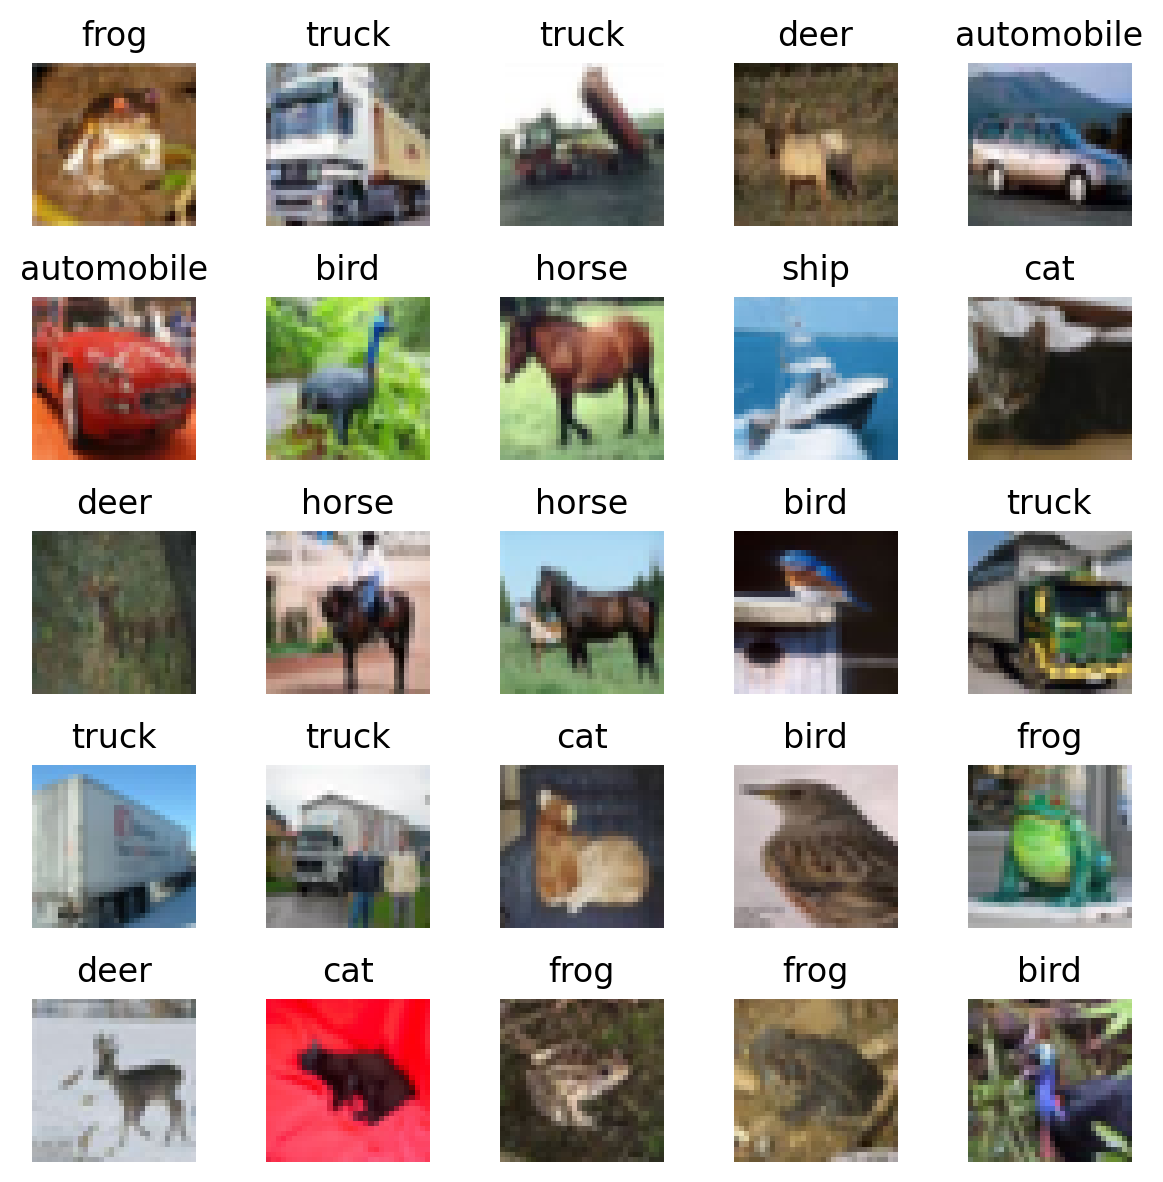

In [6]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(trainset.data[i])
    plt.axis('off')
    plt.title(trainset.classes[trainset.targets[i]])
plt.tight_layout()
    
    

In [7]:
# Create a trainset containing only the first 100 images and test set is everything else

X_train = trainset.data[:100]
y_train = trainset.targets[:100]

X_test = trainset.data[100:]
y_test = trainset.targets[100:]

# Convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.tensor(y_train)

X_test = torch.from_numpy(X_test).float()
y_test = torch.tensor(y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# But, CNNs expect n_channels x height x width
# So, we need to transpose the data

X_train = X_train.transpose(1, 3)
X_test = X_test.transpose(1, 3)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Put all Xs on a scale of 0 to 1
X_train /= 255
X_test /= 255

torch.Size([100, 32, 32, 3]) torch.Size([100]) torch.Size([49900, 32, 32, 3]) torch.Size([49900])
torch.Size([100, 3, 32, 32]) torch.Size([100]) torch.Size([49900, 3, 32, 32]) torch.Size([49900])


In [8]:
# Simple CNN model 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class Featurizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2) # 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel

    def forward(self, x):
        x = self.pool(F.gelu(self.conv1(x))) # conv1 -> relu -> pool
        x = self.pool(F.gelu(self.conv2(x))) # conv2 -> relu -> pool
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        return x

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5 input features, 120 output features
        self.fc2 = nn.Linear(120, 84) # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 10) # 84 input features, 10 output features

    def forward(self, x):
        x = F.gelu(self.fc1(x)) # fc1 -> relu
        x = F.gelu(self.fc2(x)) # fc2 -> relu
        x = self.fc3(x) # fc3
        return x

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.featurizer = Featurizer()
        self.classifier = Classifier()

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x


In [9]:
net = Net().to(device)

In [10]:
torchsummary.summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
        Featurizer-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
        Classifier-9                   [-1, 10]               0
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
---------------------------------------------

In [11]:
net

Net(
  (featurizer): Featurizer(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [12]:
nn.Conv2d(3, 6, 1)(torch.randn(1, 3, 32, 32)).shape

torch.Size([1, 6, 32, 32])

In [13]:
net(X_train.to(device)).shape

torch.Size([100, 10])

In [14]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [15]:
from astra.torch.utils import train_fn

res_dict= train_fn(net, X_train, y_train, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=500)

  0%|          | 0/500 [00:00<?, ?it/s]

Loss: 0.001345: 100%|██████████| 500/500 [00:02<00:00, 201.28it/s]


Text(0, 0.5, 'Loss')

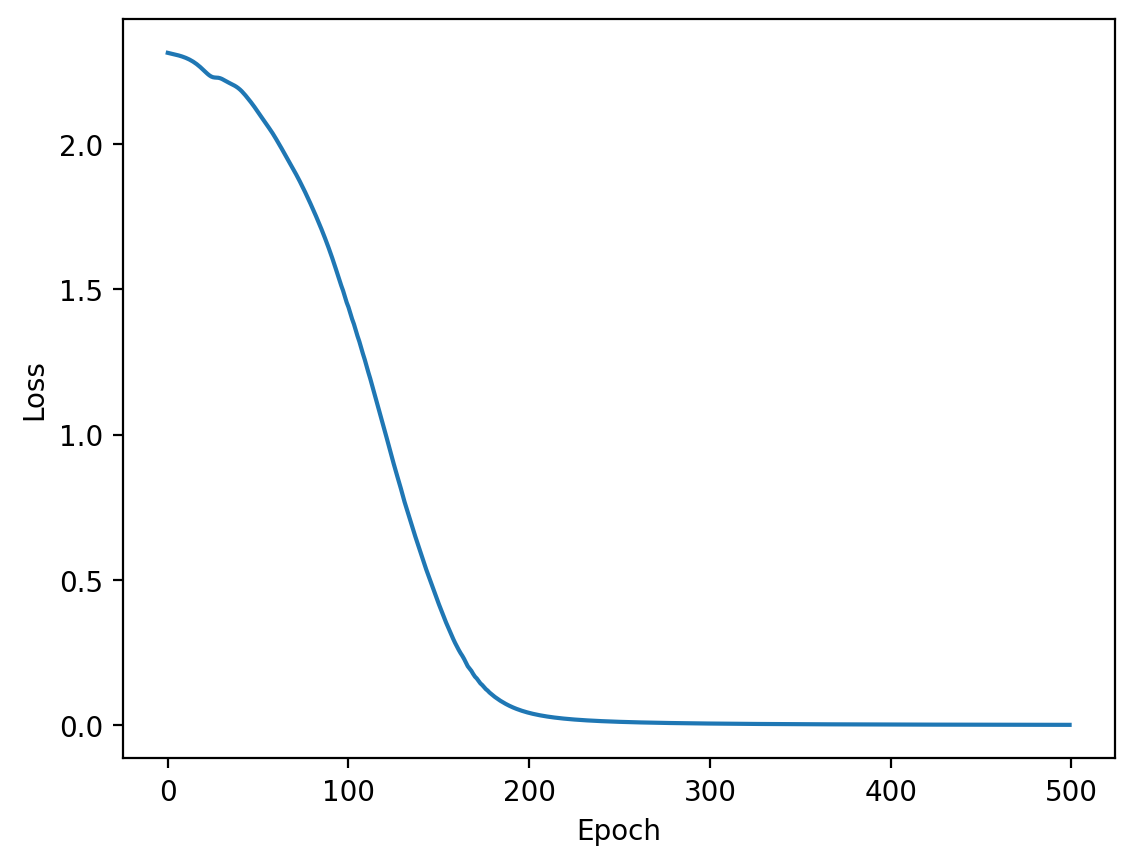

In [16]:
plt.plot(res_dict['epoch_losses'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [23]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc

def predict(net):
    y_pred_train, acc_train = get_accuracy(net, X_train, y_train)
    y_pred_test, acc_test = get_accuracy(net, X_test, y_test)
    print(f'Train accuracy: {acc_train:.2f}')
    print(f'Test accuracy: {acc_test:.2f}')
    cm_train = confusion_matrix(y_train.cpu(), y_pred_train.cpu())
    cm_test = confusion_matrix(y_test.cpu(), y_pred_test.cpu())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    cm_train_display = ConfusionMatrixDisplay(cm_train, display_labels=trainset.classes).plot(values_format='d'
                                                                , cmap='Blues'
                                                                , ax=ax1)
    
    cm_test_display = ConfusionMatrixDisplay(cm_test, display_labels=trainset.classes).plot(values_format='d'
                                                                , cmap='Blues'
                                                                , ax=ax2)

    # Rotate the labels on x-axis to make them readable
    _ = ax1.set_xticklabels(trainset.classes, rotation=90)
    _ = ax2.set_xticklabels(trainset.classes, rotation=90)
    

Train accuracy: 1.00
Test accuracy: 0.19


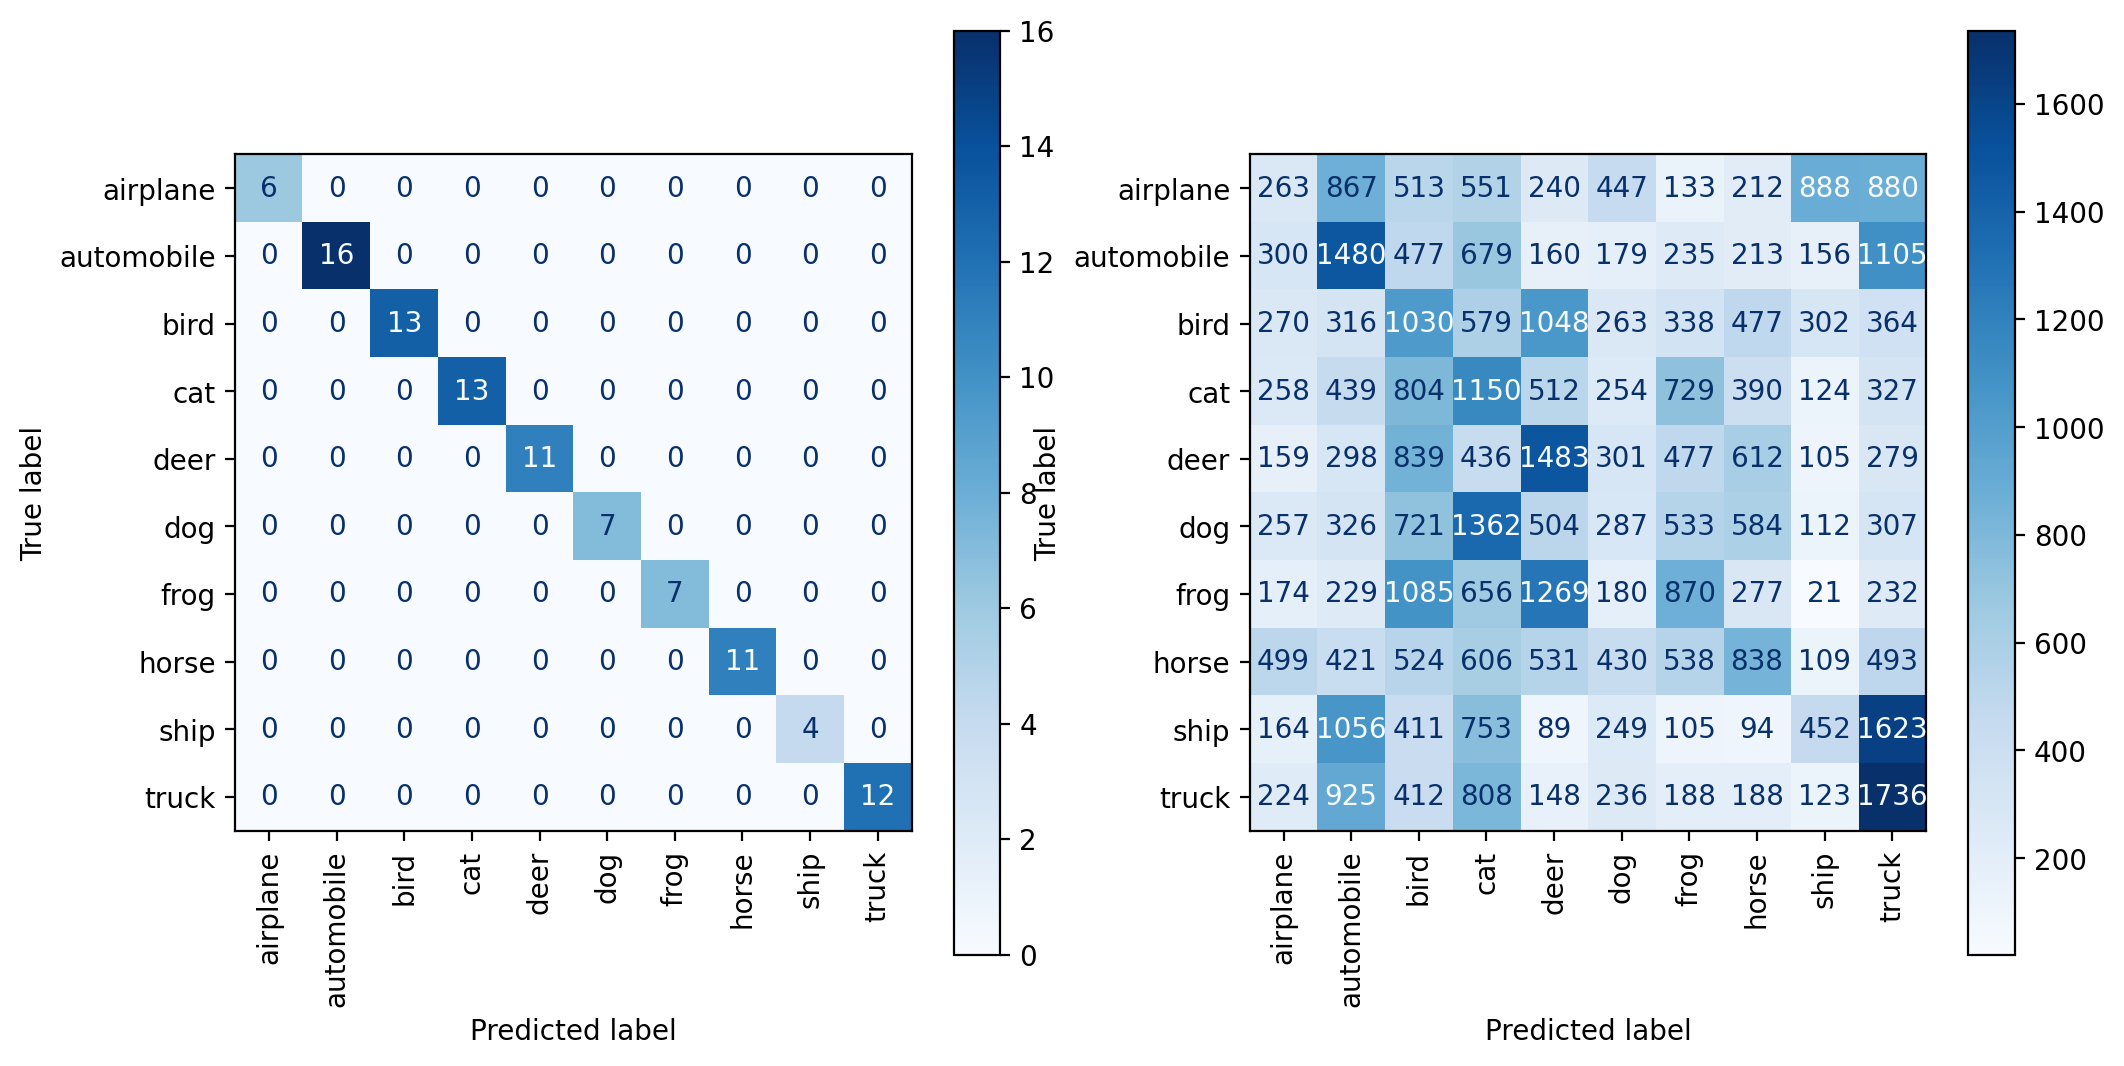

In [24]:
predict(net)

#### TODO

In [30]:
### Creating a (barebones) ResNet model with comparable number of parameters
# Without batchnorm, dropout, etc.

# Simple CNN model 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class ResidualFeaturizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2) # 3 input channels, 6 output channels, 5x5 kernel
        # Output size = (W - F + 2P)/S + 1 = (32 - 5 + 2*2)/1 + 1 = 32
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2)
        # Output size = (W - F + 2P)/S + 1 = (32 - 5 + 2*2)/1 + 1 = 32
        self.conv3 = nn.Conv2d(16, 16, 5, padding=2)
        self.conv4 = nn.Conv2d(16, 16, 5, padding=2)
        self.conv5 = nn.Conv2d(16, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4096, 400) # 16 * 5 * 5 input features, 400 output features
        
    def forward(self, x):
        x1 = F.gelu(self.conv1(x)) # (3, 32, 32) -> (6, 32, 32)
        x2 = F.gelu(self.conv2(x1)) # (6, 32, 32) -> (16, 32, 32)
        x3 = F.gelu(self.conv3(x2)) # (16, 32, 32) -> (16, 32, 32)
        x4 = F.gelu(self.conv4(x3) + x2) # (16, 32, 32) -> (16, 32, 32)
        x5 = F.gelu(self.conv5(x4))
        #x5 = F.gelu(self.conv5(x4) + x3) # (16, 32, 32) -> (16, 32, 32)
        x6 = self.pool(x5) # (16, 32, 32) -> (16, 16, 16)
        x7 = F.gelu(self.flatten(x6)) # (16, 16, 16) -> (4096)
        x8 = self.fc1(x7) # (4096) -> (400)
        
        return x8

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.featurizer = ResidualFeaturizer()
        self.classifier = Classifier()

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x


In [37]:
res_feat = ResidualFeaturizer().to(device)
print(res_feat(torch.randn(1, 3, 32, 32).to(device)).shape)

res_net = ResNet().to(device)
print(res_net(torch.randn(1, 3, 32, 32).to(device)).shape)

torch.Size([1, 400])
torch.Size([1, 10])


In [38]:
res_dict = train_fn(res_net, X_train, y_train, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=100)

Loss: 0.005024: 100%|██████████| 100/100 [00:00<00:00, 167.74it/s]


Train accuracy: 1.00
Test accuracy: 0.17


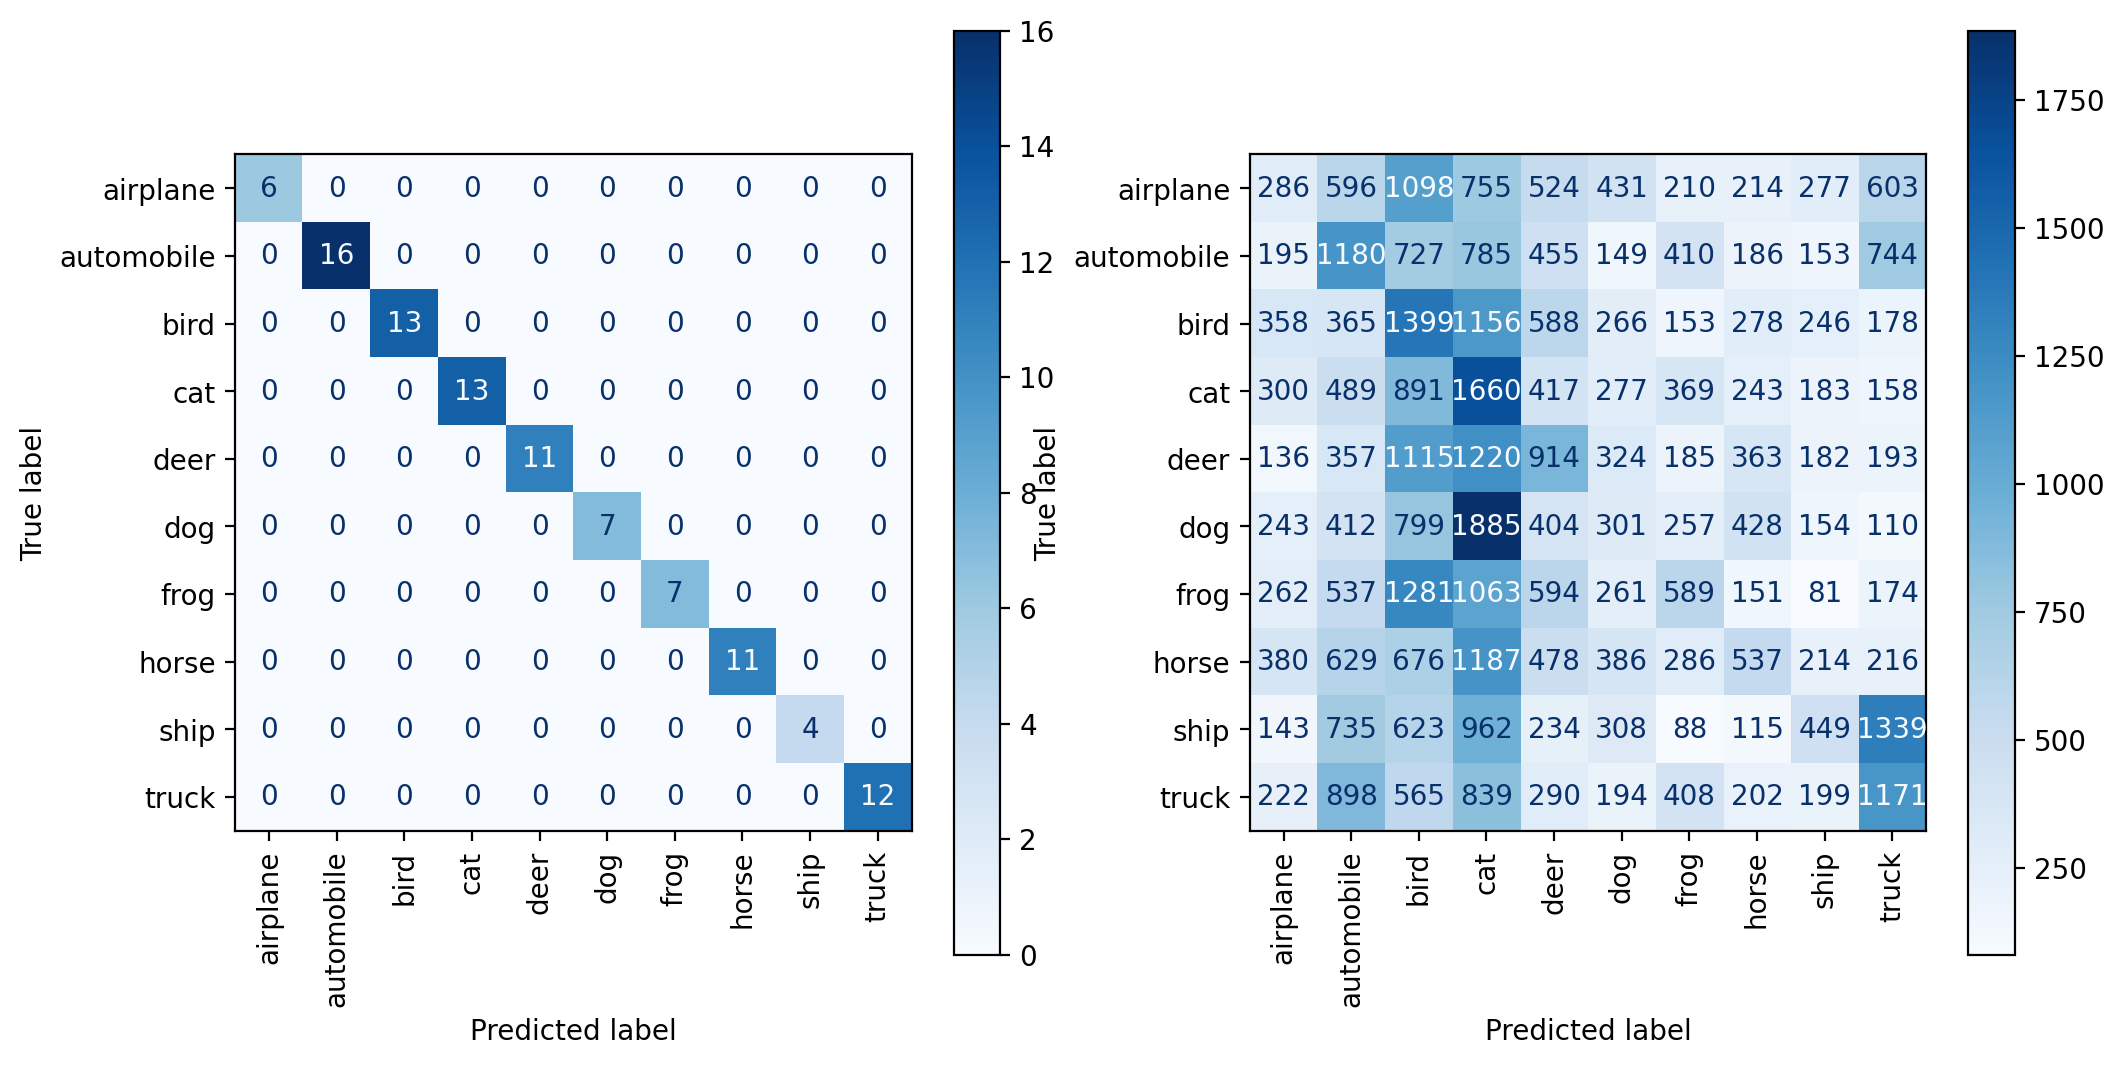

In [39]:
predict(res_net)

In [41]:
# Define data augmentation transformations
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(2),
    transforms.RandomVerticalFlip(),
])

In [42]:
def plot_orginal_and_augmented_images(image_id):
    # Function to plot images in one row
    def plot_images(images, titles):
        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        for i in range(len(images)):
            axes[i].imshow(images[i])
            axes[i].set_title(titles[i])
            axes[i].axis('off')
        plt.show()

    # Select the original image and create augmented images
    original_image = X_train[image_id].permute(1, 2, 0).cpu().numpy() 

    # Create a list to store augmented images
    augmented_images = [original_image]
    augmented_titles = ["Original Image"]

    # Apply augmentations and add the transformed images to the list
    for _ in range(5):
        transformed_image = augmentation(X_train[image_id]).permute(1, 2, 0).cpu().numpy() 
        augmented_images.append(transformed_image)
        augmented_titles.append("Augmented Image")

    # Plot the original image and augmented images in one row
    plot_images(augmented_images, augmented_titles)


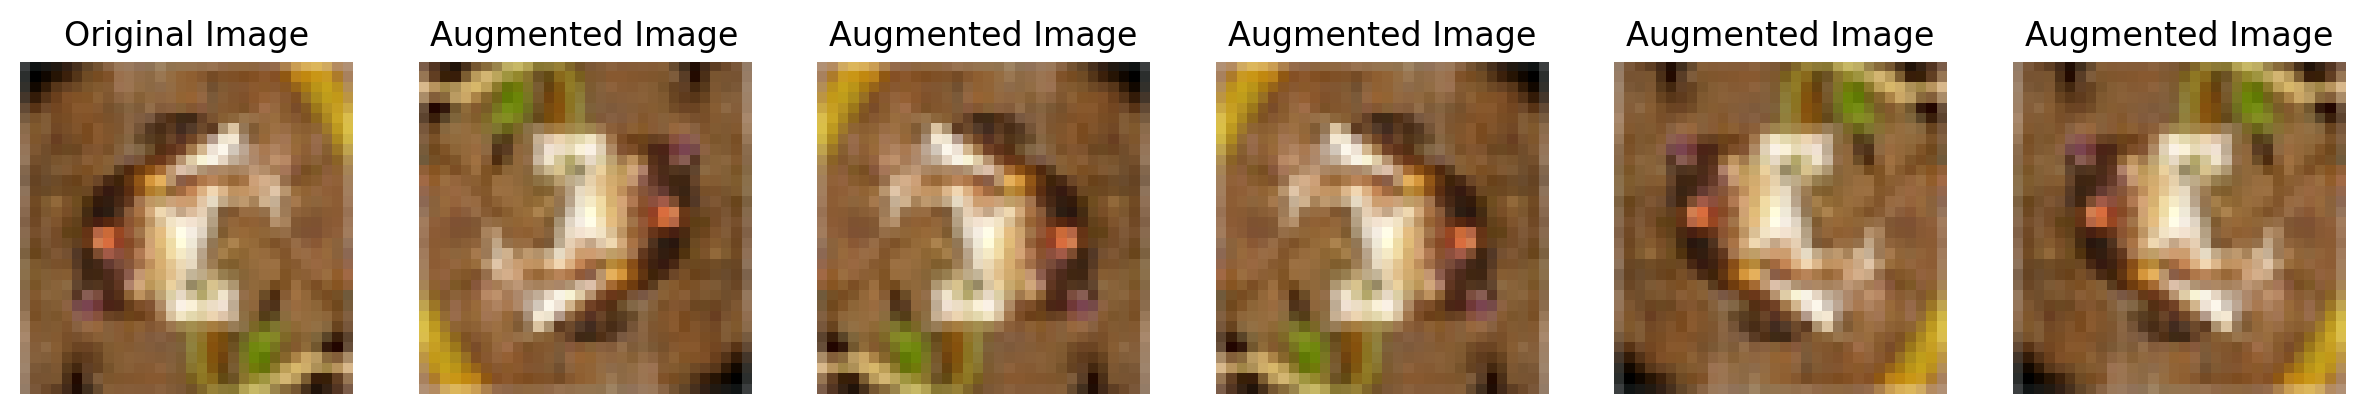

In [43]:
plot_orginal_and_augmented_images(0)

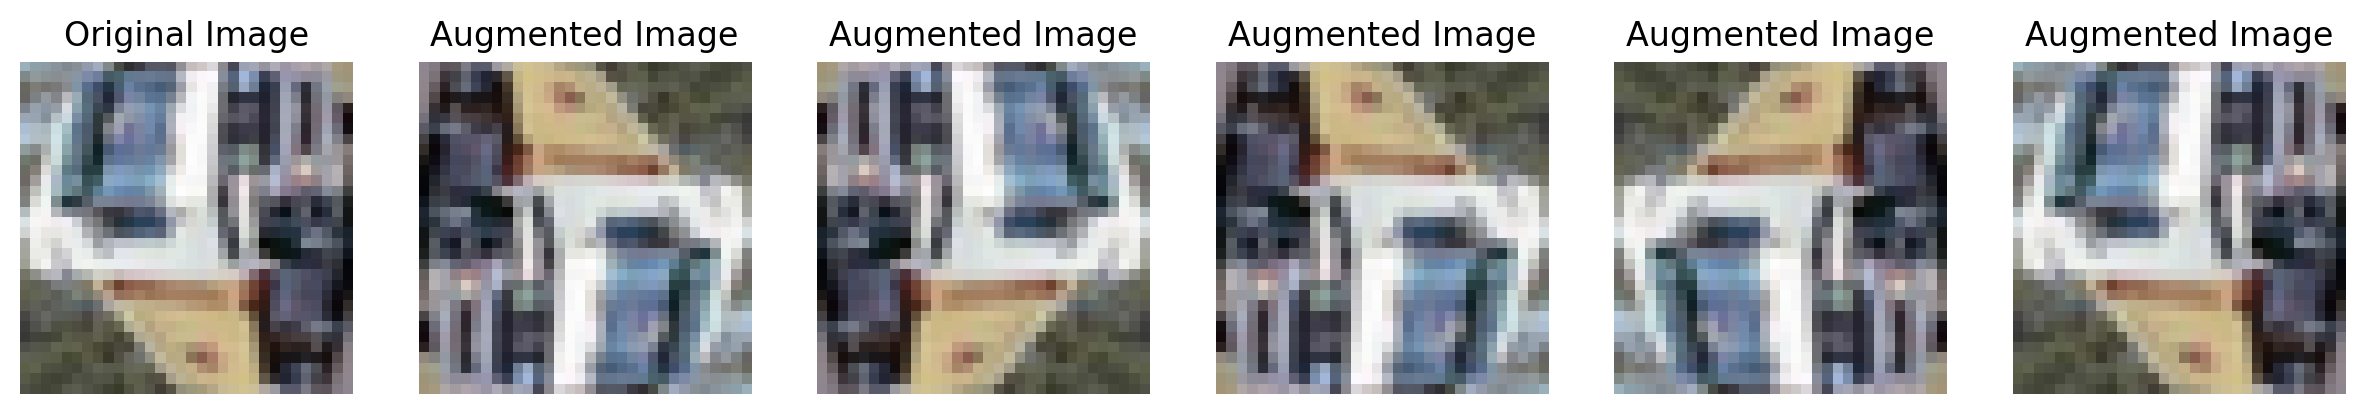

In [44]:
plot_orginal_and_augmented_images(1)

In [45]:
# Create augmented dataset with 5 augmented images per original image

X_augmented = []
y_augmented = []

# Number of augmented images per original image
num_augmentations = 10

for i in range(len(X_train)):
    for _ in range(num_augmentations):
        augmented_image = augmentation(X_train[i]).permute(1, 2, 0).cpu().numpy() 
        X_augmented.append(augmented_image)
        y_augmented.append(y_train[i].cpu())

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)
# Convert the lists to tensors
X_augmented = torch.from_numpy(X_augmented).float()
y_augmented = torch.tensor(y_augmented)

print(X_augmented.shape, y_augmented.shape)
    

torch.Size([1000, 32, 32, 3]) torch.Size([1000])


In [46]:
X_train.shape, y_train.shape

(torch.Size([100, 3, 32, 32]), torch.Size([100]))

In [47]:
# Get X_augmented and y_augmented to the device and in correct shape
X_augmented = X_augmented.to(device).transpose(1, 3)
y_augmented = y_augmented.to(device)

print(X_augmented.shape, y_augmented.shape)

torch.Size([1000, 3, 32, 32]) torch.Size([1000])


In [48]:
# Stack the original and augmented data
X_train_augmented = torch.cat([X_train, X_augmented])
y_train_augmented = torch.cat([y_train, y_augmented])

print(X_train_augmented.shape, y_train_augmented.shape)

torch.Size([1100, 3, 32, 32]) torch.Size([1100])


In [49]:
net = Net().to(device)
res_dict = train_fn(net, X_train_augmented, y_train_augmented, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=500)

Loss: 0.007195: 100%|██████████| 500/500 [00:06<00:00, 76.21it/s]


Train accuracy: 1.00
Test accuracy: 0.19


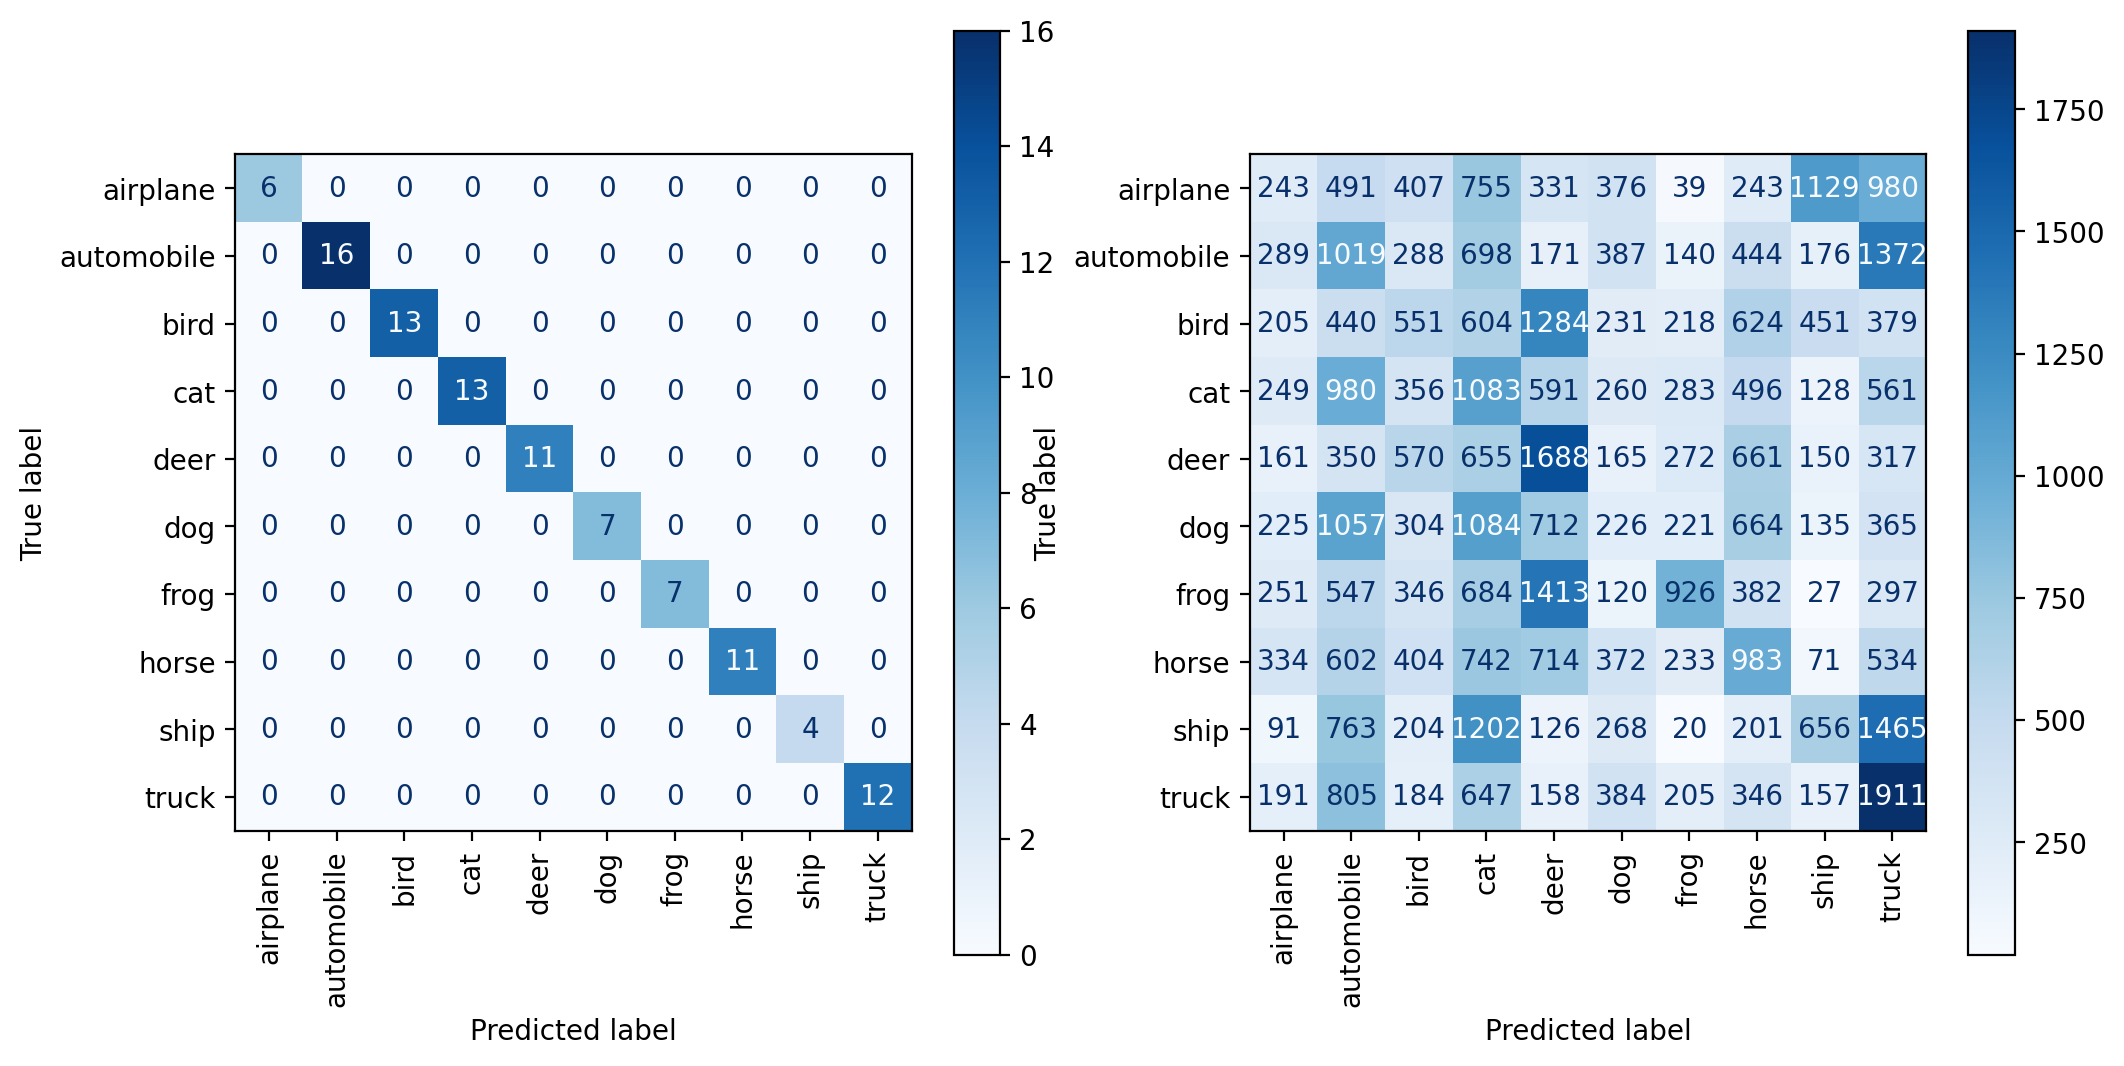

In [50]:
predict(net)

In [51]:
import pandas as pd
pd.DataFrame(X_train[0][0].cpu()).describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.510539,0.418137,0.441912,0.454289,0.437500,0.402328,0.418015,0.455392,0.455515,0.464461,...,0.580882,0.571691,0.584681,0.586029,0.587500,0.572181,0.558701,0.554167,0.554289,0.628431
std,0.126123,0.137375,0.116168,0.096425,0.088488,0.102087,0.103764,0.138375,0.151614,0.109858,...,0.097018,0.125335,0.134465,0.084196,0.089033,0.107951,0.136913,0.148528,0.152076,0.128834
min,0.168627,0.000000,0.062745,0.129412,0.196078,0.125490,0.227451,0.160784,0.172549,0.243137,...,0.423529,0.329412,0.301961,0.474510,0.458824,0.278431,0.129412,0.196078,0.133333,0.360784
25%,0.501961,0.414706,0.437255,0.439216,0.412745,0.345098,0.340196,0.399020,0.328431,0.391176,...,0.528431,0.532353,0.514706,0.529412,0.523529,0.525490,0.498039,0.529412,0.504902,0.560784
50%,0.545098,0.468627,0.476471,0.476471,0.468627,0.419608,0.429412,0.486275,0.494118,0.500000,...,0.566667,0.580392,0.586275,0.552941,0.584314,0.558824,0.556863,0.560784,0.552941,0.633333
75%,0.584314,0.495098,0.506863,0.510784,0.492157,0.472549,0.500000,0.526471,0.519608,0.533333,...,0.594118,0.624510,0.659804,0.642157,0.604902,0.584314,0.600980,0.611765,0.678431,0.696078
max,0.658824,0.521569,0.556863,0.572549,0.552941,0.549020,0.592157,0.819608,0.850980,0.611765,...,0.803922,0.831373,0.878431,0.827451,0.843137,0.847059,0.862745,0.815686,0.788235,0.854902


In [52]:
pd.DataFrame(X_augmented[0][0].cpu()).describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.466422,0.489951,0.537500,0.515564,0.473162,0.494118,0.547917,0.584681,0.577941,0.581740,...,0.606618,0.584314,0.553064,0.519240,0.510172,0.532230,0.535784,0.518995,0.500735,0.531373
std,0.157931,0.144774,0.140093,0.098848,0.095216,0.075761,0.061847,0.171810,0.199998,0.173617,...,0.159365,0.159127,0.149917,0.140471,0.124702,0.094114,0.117692,0.152252,0.196014,0.207971
min,0.125490,0.137255,0.262745,0.345098,0.133333,0.227451,0.407843,0.329412,0.294118,0.290196,...,0.396078,0.329412,0.317647,0.258824,0.247059,0.345098,0.200000,0.070588,0.000000,0.062745
25%,0.392157,0.455882,0.465686,0.460784,0.446078,0.483333,0.512745,0.484314,0.465686,0.479412,...,0.487255,0.466667,0.461765,0.455882,0.473529,0.485294,0.501961,0.497059,0.464706,0.515686
50%,0.505882,0.498039,0.519608,0.513726,0.494118,0.509804,0.537255,0.545098,0.529412,0.539216,...,0.543137,0.554902,0.535294,0.507843,0.505882,0.519608,0.547059,0.543137,0.535294,0.568627
75%,0.535294,0.545098,0.581373,0.538235,0.522549,0.530392,0.593137,0.610784,0.623529,0.711765,...,0.713726,0.668627,0.608824,0.577451,0.550980,0.535294,0.577451,0.580392,0.603922,0.607843
max,0.780392,0.827451,0.847059,0.796078,0.623529,0.658824,0.650980,0.945098,0.980392,0.941176,...,0.972549,0.988235,0.956863,0.858824,0.854902,0.792157,0.760784,0.776471,0.788235,0.862745


### SSL
#### Task 1: Predict angle of rotation (0, 90, 180, 270) as a classification task

Create a dataset with rotated images and corresponding labels. We can now use a much larger dataset



In [53]:
X_all_orginal = torch.cat([X_train, X_test])
y_all_orginal = torch.cat([y_train, y_test])


X_all_orginal.shape, y_all_orginal.shape

(torch.Size([50000, 3, 32, 32]), torch.Size([50000]))

In [296]:
X_ssl = []
y_ssl = []

angles_map = {0:0, 90:1, 180:2, 270:3}
for i in range(len(X_all_orginal))[:5000]:
    for angle_rot in angles_map.keys():
        transformed_image = transforms.functional.rotate(X_all_orginal[i], angle_rot)
        X_ssl.append(transformed_image)
        y_ssl.append(angles_map[angle_rot])

X_ssl = torch.stack(X_ssl).to(device)
y_ssl = torch.tensor(y_ssl).to(device)

In [297]:
X_ssl.shape, y_ssl.shape

(torch.Size([20000, 3, 32, 32]), torch.Size([20000]))

In [298]:
y_ssl[0]

tensor(0, device='cuda:0')

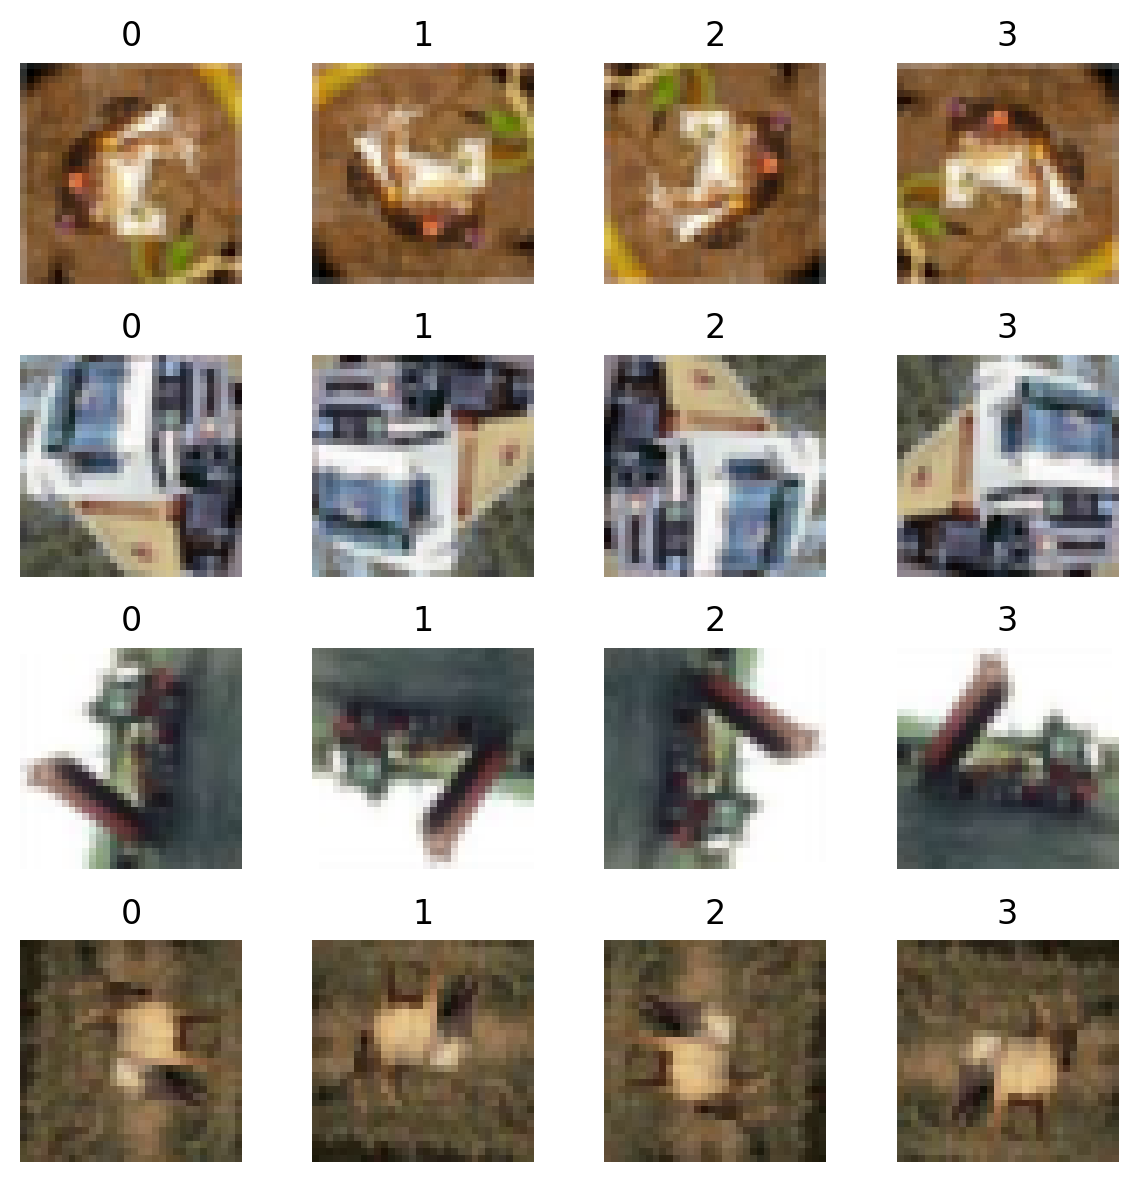

In [300]:
# View the images
plt.figure(figsize=(6, 6))
n_imgs = 16
for i in range(n_imgs):
    plt.subplot(n_imgs//4, 4, i+1)
    plt.imshow(X_ssl[i].cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.title(y_ssl[i].item())
plt.tight_layout()

In [301]:

class AngleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5 input features, 120 output features
        self.fc2 = nn.Linear(120, 84) # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 4) # 84 input features, 4 output features

    def forward(self, x):
        x = F.gelu(self.fc1(x)) # fc1 -> relu
        x = F.gelu(self.fc2(x)) # fc2 -> relu
        x = self.fc3(x) # fc3
        return x

class SSLAngle(nn.Module):
    def __init__(self):
        super().__init__()
        self.featurizer = Featurizer()
        self.classifier = AngleClassifier()

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x
    

In [302]:
ssl_angle = SSLAngle().to(device)

In [303]:
res_dict = train_fn(ssl_angle, X_ssl, y_ssl, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=200)

Loss: 1.072848: 100%|██████████| 200/200 [00:51<00:00,  3.91it/s]


In [304]:
# Now, we can use the features from SSLAngle model to train the classifier on the original data

net_pretrained = Net().to(device)
net_pretrained.featurizer.load_state_dict(ssl_angle.featurizer.state_dict())

res_dict = train_fn(net_pretrained, X_train, y_train, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=500)


Loss: 0.001218: 100%|██████████| 500/500 [00:02<00:00, 211.46it/s]


Accuracy Test: 20.30%
Accuracy Train: 100.00%


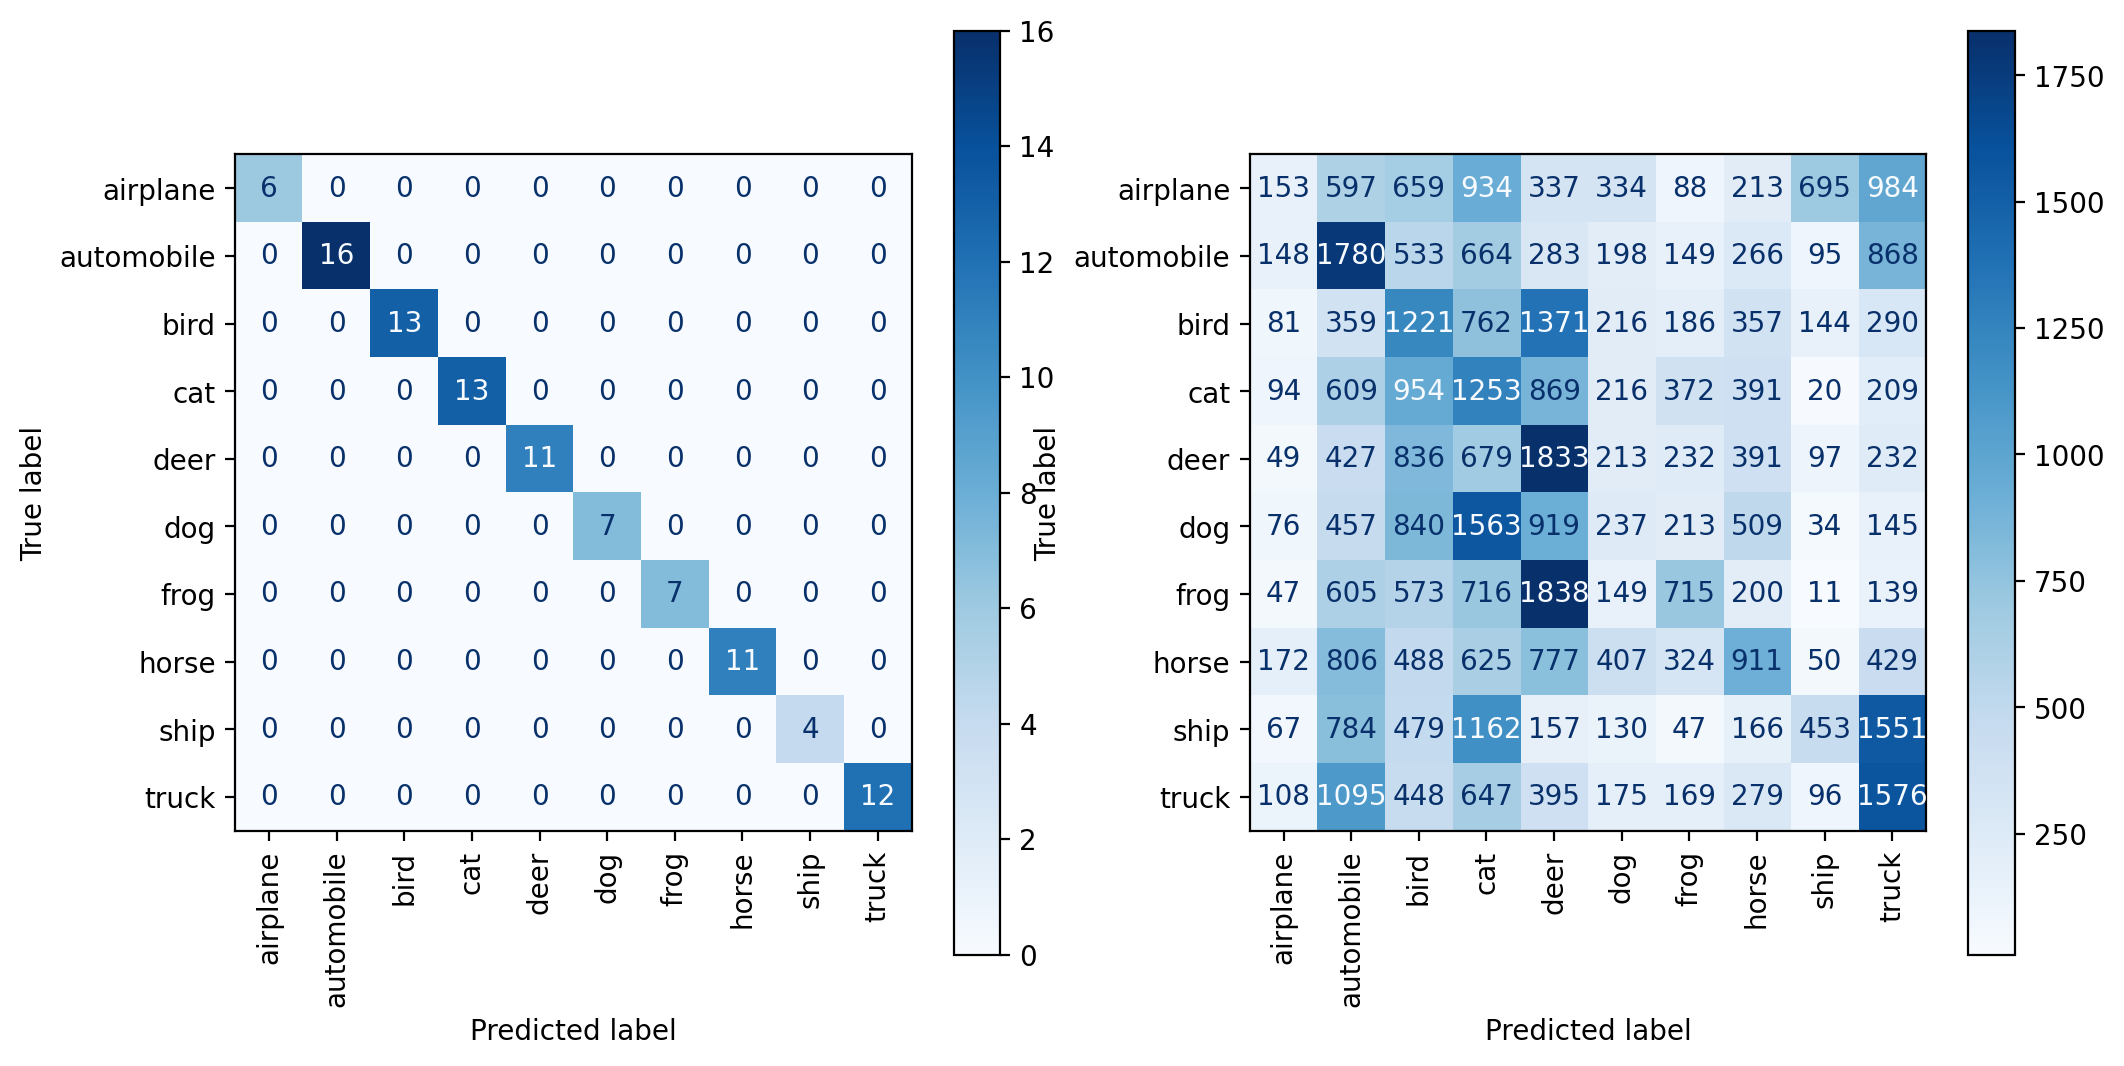

In [305]:
predict(net_pretrained)